## Example with CNN-LSTM on live BTC close price using the full data

In [16]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [19]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169436, 8)


### Generate Candles and build features from technical analysis

In [20]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 10000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 10000 steps
Generated time-series
Normalized 'candles_norm' with shape : (10000, 9)
Feature data 'x_candles' with size : 9952
Feature data with time intervals 'x_time' with size : 9952


In [21]:
USE_PRETRAINED = True
PRESAVED_MODELDATE='220615_18_16'
initial_timestamp = pd.Timestamp(datetime.strptime('220615_18_16', '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
preds = ts_btc.denorm(loaded_model.preds)

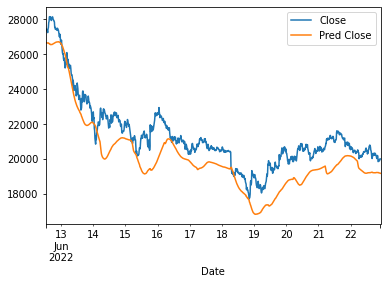

In [22]:
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.iloc[-1000:].plot()

In [23]:
def kelly_exp_returns(returns):

  drift = np.mean(returns)
  variance = np.var(returns)
  kelly_frac = drift/variance
  return kelly_frac

def kelly_exp_simple(pct_gain,pct_loss,n_wins):

  win_loss_ratio = pct_gain/pct_loss
  kelly_frac = n_wins - (1- n_wins)/win_loss_ratio
  return kelly_frac

def backtest_df(df_preds_true, long_or_short = "long", fee=0.025):

    if long_or_short == "short":
            long = False
    elif long_or_short == "long":
            long = True
    else:
        raise ValueError("Can only have long or short")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0
    mean_pct_gain = 0
    mean_pct_loss = 0

    previous_true_close = df_preds_true.iloc[0,0]
    previous_pred_close = df_preds_true.iloc[0,-1]

    for index, row in df_preds_true.iloc[1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]

        if long:
            if previous_pred_close + previous_true_close * fee < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += true_close/previous_true_close
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += true_close/previous_true_close
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close

        else:
            if  previous_pred_close + previous_true_close *fee > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)
                    # print(f"profit {profit}")
                    # print(f"{index}, true {true_close}, pred {pred_close}")
                    # print(f"prev true {previous_true_close}, prev pred {previous_pred_close}")                    
                else:
                    #loss
                    profit = -1*(profit + (profit * fee))
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close

    mean_pct_gain /= buys_cnt_win
    mean_pct_loss /= buys_cnt_losses
    
    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('Avg PCT gain:', mean_pct_gain)
    print('Avg PCT loss:', mean_pct_loss)
    print('Wins    ', buys_cnt/len(df_preds_true))
    print('Avg Gain.   ', buys_cnt_win/buys_cnt_losses)
    print('No-op   ', len(df_preds_true) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    kelly_frac = kelly_exp_simple(mean_pct_gain,mean_pct_loss,buys_cnt_win/len(df_preds_true))

    print('Kelly Fraction   ',kelly_frac)

    return total_wallet_history, single_wallet_history, wallet, kelly_frac

Fee: 0.025
----------------------
Buy      9950 ( 4947 ok 5003 ko )
Avg PCT gain: 1.0025000988733823
Avg PCT loss: 0.9976760207872766
Wins     0.9998995075871772
Avg Gain.    0.9888067159704178
No-op    1
Wallet   -804.0667500000596
Drawback -2244.278500000001
Kelly Fraction    -0.0033082619186077244
Total earned -804.0667500000596


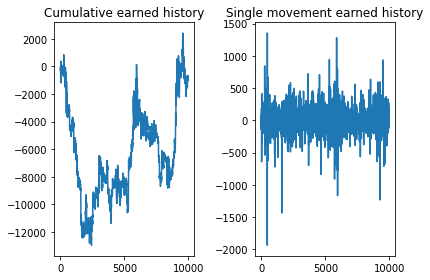

In [24]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = backtest_df(df_preds_true.dropna(), long_or_short = "short", fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [ ]:
df_preds_true.dropna().iloc[1]

Close         29157.180000
Pred Close    28709.565921
Name: 2022-06-10 17:16:00, dtype: float64